In [1]:
import moxing as mox

mox.file.copy_parallel('obs://mybocket/imagenet.zip', 'imagenet.zip')
# 把 bucket_name 替换成你的桶名
# 实际上会复制到虚拟机中的 /home/ma-user/work/TinyImageNet.zip
# 因为 Jupyter Lab 的工作目录是 /home/ma-user/work

INFO:root:Using MoXing-v1.17.3-
INFO:root:Using OBS-Python-SDK-3.20.7


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
from torch.autograd import Variable
from torchvision import transforms, models
from torch.utils import model_zoo

from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
path = '/home/ma-user/work/TinyImageNet/'

In [4]:
train_label = pd.read_csv(path+'train.txt', sep=' ', names=['image', 'label'])
test = pd.read_csv(path+'test.txt', sep=' ', names=['image'])
val_label = pd.read_csv(path+'val.txt', sep=' ', names=['image', 'label'])

print('train size: ', train_label.shape)
print('val size: ', val_label.shape)
print('test size: ', test.shape)

train size:  (100000, 2)
val size:  (10000, 2)
test size:  (10000, 1)


In [5]:
class data(Dataset):
    def __init__(self, type, transform):
        self.type = type
        if type == 'train':
            self.train_images = []
            for row in train_label.itertuples(index=True, name='Pandas'):
                # print(getattr(row, 'image'))
                image_path = os.path.join(path, getattr(row, 'image'))
                self.train_images.append(cv2.imread(image_path))
            self.train_images = np.array(self.train_images)
            
        elif type == 'val':
            self.val_images = []
            for row in val_label.itertuples(index=True, name='Pandas'):
                # print(getattr(row, 'image'))
                image_path = os.path.join(path, getattr(row, 'image'))
                self.val_images.append(cv2.imread(image_path))
            self.val_images = np.array(self.val_images)
            
        self.transform = transform
        
    def __getitem__(self, index):
        label = []
        image = []
        if self.type == 'train':
            label = train_label.loc[index, 'label']
            image = self.train_images[index]
        if self.type == 'val':
            label = val_label.loc[index, 'label']
            image = self.val_images[index]
        return self.transform(image), label 
        
    def __len__(self):
        length = 0
        if self.type == 'train':
            length = self.train_images.shape[0]
        if self.type == 'val':
            length = self.val_images.shape[0]
        return length


In [6]:
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.RandomCrop((224, 224), padding=4),
    transforms.ToTensor(),  
#     normTransform
])

In [7]:
train_dataset = data('train', transform=trans)
val_dataset = data('val', transform=trans)

In [8]:
batch_size = 128
val_batch_size = 128

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=val_batch_size, shuffle=False)


In [9]:
# mox.file.copy_parallel('obs://mybocket/pretrained/se_resnet152-d17c99b7.pth', 'se_resnet152-d17c99b7.pth')
# mox.file.copy_parallel('obs://mybocket/pretrained/senet154-c7b49a05.pth', 'senet154-c7b49a05.pth')
# mox.file.copy_parallel('obs://mybocket/pretrained/my_seresnet152_2.pth', 'my_seresnet152_2.pth')
mox.file.copy_parallel('obs://mybocket/pretrained/se_resnext101_32x4d-3b2fe3d8.pth', 'se_resnext101_32x4d-3b2fe3d8.pth')

In [10]:
"""
部分代码参考自
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""


__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    #seresnet_state_dict = torch.load('./se_resnet152-d17c99b7.pth')
    #seresnet_state_dict = torch.load('./senet154-c7b49a05.pth')
    seresnet_state_dict = torch.load('se_resnext101_32x4d-3b2fe3d8.pth')
    #se_resnext101_32x4d-3b2fe3d8.pth
    model.load_state_dict(seresnet_state_dict)
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']

def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [11]:
class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()
        #self.resnet = models.resnet101()
        #self.se_resnet = se_resnet152(pretrained='imagenet')
        self.se_resnet = se_resnext101_32x4d(pretrained='imagenet')
        self.linear1 = torch.nn.Linear(in_features=1000, out_features=512)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=256)
        self.linear3 = torch.nn.Linear(in_features=256, out_features=100)
        
    def forward(self, x):
        x = self.se_resnet(x)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x


In [12]:
'''
def build_model(path):
    #加载预训练参数
    # vgg_state_dict = torch.load(path) 
    seresnet_state_dict = torch.load(path)
    model = Mymodel()
    model.load_state_dict(seresnet_state_dict)
        
    return model
'''

'\ndef build_model(path):\n    #加载预训练参数\n    # vgg_state_dict = torch.load(path) \n    seresnet_state_dict = torch.load(path)\n    model = Mymodel()\n    model.load_state_dict(seresnet_state_dict)\n        \n    return model\n'

In [13]:
# mox.file.copy_parallel('obs://mybocket/se_resnet152-d17c99b7.pth.zip', 'se_resnet152-d17c99b7.pth.zip')

In [14]:
# model = build_model(path='my_seresnet152_2.pth')
# ../input/senet154a/models/senet154-c7b49a05.pth
# ../input/seresnext50/se_resnext50_32x4d-a260b3a4.pth
model = Mymodel()
print(model)

Mymodel(
  (se_resnet): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

In [15]:
max_epoch = 3

In [16]:

use_gpu = torch.cuda.is_available()

Train_Accuracy = []
Val_Accuracy = []
Train_Loss = []
Val_Loss = []

In [17]:
use_gpu

True

In [18]:
if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss() 
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.95)
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), weight_decay=1e-5)


    
for epoch in range(max_epoch):
    train_acc_sum = 0
    train_sum = 0
    val_acc_sum = 0
    val_sum = 0
    train_Accuracy = []
    val_Accuracy = []
    train_Loss = []
    val_Loss = []

    model.train()
    print('***Training***')
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # Forward pass: Compute predicted y by passing X to the model
        y_pred = model(inputs)
        y_predict = y_pred.argmax(axis=1)
        
        train_acc_sum += float(sum(y_predict == labels))
        train_sum += float(len(labels))
        
        acc = train_acc_sum / float(train_sum)
        train_Accuracy.append(acc)
        
        # Compute and print Loss
        loss = criterion(y_pred, labels)
        if use_gpu: loss = loss.cpu()
        train_Loss.append(loss)
        
        if i % 100 == 0: 
            print('Epoch: {}\t Batch: {}\t Loss: {:.4f}\t Accuracy: {:.4f} '.format(epoch, i, loss, acc))
        
        # Zero gradients, perform a backward pass, and update the weights.
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Train_Loss.append(float(torch.stack(train_Loss).mean()))
    Train_Accuracy.append(np.array(train_Accuracy).mean())
    
    torch.cuda.empty_cache()
    ################################
    with torch.no_grad():
        model.eval()
        print('***Validating***')
        for i, data in enumerate(val_dataloader, 0):
            # get the inputs
            inputs, labels = data
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # Forward pass: Compute predicted y by passing X to the model
            y_pred = model(inputs)
            y_predict = y_pred.argmax(axis=1)

            val_acc_sum += float(sum(y_predict == labels))
            val_sum += float(len(labels))
            acc = val_acc_sum / float(val_sum)
            val_Accuracy.append(acc)

            loss = criterion(y_pred, labels)
            if use_gpu: loss = loss.cpu()
            val_Loss.append(loss)

            if i % 10 == 0: 
                print('Epoch: {}\t Batch: {}\t Loss: {:.4f}\t Accuracy: {:.4f} '.format(epoch, i, loss, acc))

        Val_Loss.append(float(torch.stack(val_Loss).mean()))
        Val_Accuracy.append(np.array(val_Accuracy).mean())
    

***Training***
Epoch: 0	 Batch: 0	 Loss: 4.6027	 Accuracy: 0.0156 
Epoch: 0	 Batch: 100	 Loss: 1.6350	 Accuracy: 0.4871 
Epoch: 0	 Batch: 200	 Loss: 1.1669	 Accuracy: 0.5766 
Epoch: 0	 Batch: 300	 Loss: 1.1285	 Accuracy: 0.6183 
Epoch: 0	 Batch: 400	 Loss: 1.0202	 Accuracy: 0.6454 
Epoch: 0	 Batch: 500	 Loss: 0.8077	 Accuracy: 0.6643 
Epoch: 0	 Batch: 600	 Loss: 0.9546	 Accuracy: 0.6805 
Epoch: 0	 Batch: 700	 Loss: 0.9082	 Accuracy: 0.6926 
***Validating***
Epoch: 0	 Batch: 0	 Loss: 1.0857	 Accuracy: 0.7266 
Epoch: 0	 Batch: 10	 Loss: 1.1184	 Accuracy: 0.7805 
Epoch: 0	 Batch: 20	 Loss: 0.6787	 Accuracy: 0.7798 
Epoch: 0	 Batch: 30	 Loss: 0.6239	 Accuracy: 0.7944 
Epoch: 0	 Batch: 40	 Loss: 1.1448	 Accuracy: 0.7851 
Epoch: 0	 Batch: 50	 Loss: 0.5118	 Accuracy: 0.7727 
Epoch: 0	 Batch: 60	 Loss: 1.2677	 Accuracy: 0.7642 
Epoch: 0	 Batch: 70	 Loss: 1.5114	 Accuracy: 0.7666 
***Training***
Epoch: 1	 Batch: 0	 Loss: 0.7153	 Accuracy: 0.7969 
Epoch: 1	 Batch: 100	 Loss: 0.7219	 Accuracy: 0.

In [19]:
torch.cuda.empty_cache()

In [20]:
torch.save(model.state_dict(),'./my_seresnext101_3ep.pth')

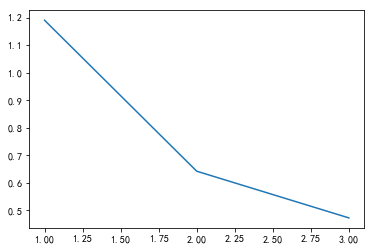

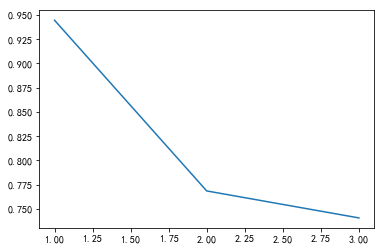

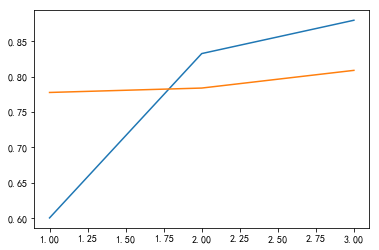

In [22]:
plt.plot(range(1,4), Train_Loss)
plt.savefig('TrainLoss_seresnext101_3ep', dpi=300)
plt.show()

plt.plot(range(1,4), Val_Loss)
plt.savefig('ValLoss_seresnext101_3ep', dpi=300)
plt.show()

plt.plot(range(1,4), Train_Accuracy)
plt.plot(range(1,4), Val_Accuracy)
plt.savefig('Accuracy_seresnext101_3ep', dpi=300)
plt.show()

In [23]:
if(use_gpu):
    inputs = inputs.cpu()
    labels = labels.cpu()

In [24]:
class test_data(Dataset):
    def __init__(self, transform):
        self.test_images = []
        self.id = []
        for row in test.itertuples(index=True, name='Pandas'):
            # print(getattr(row, 'image'))
            image_path = os.path.join(path, getattr(row, 'image'))
            self.test_images.append(cv2.imread(image_path))
            self.id.append(getattr(row, 'image').replace('test/', ''))
        self.test_images = np.array(self.test_images)
        self.id = np.array(self.id)
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.id[index]
        image = self.test_images[index]
        return self.transform(image), label 
        
    def __len__(self):
        length = 0   
        length = self.test_images.shape[0]
        return length


In [25]:
test_dataset = test_data(transform=trans)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=test.shape[0], shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [26]:
'''
with torch.no_grad():
    torch.cuda.empty_cache()
    model = model.cuda()
    for i, data in enumerate(test_dataloader, 0):
        # get the inputs
        inputs, ids = data
        if use_gpu:
            inputs = inputs.cuda()

        inputs = Variable(inputs)
        test_pred = model(inputs)
        test_Sub = test_pred.argmax(axis=1)  
        test_Sub = test_Sub.cpu()
'''

'\nwith torch.no_grad():\n    torch.cuda.empty_cache()\n    model = model.cuda()\n    for i, data in enumerate(test_dataloader, 0):\n        # get the inputs\n        inputs, ids = data\n        if use_gpu:\n            inputs = inputs.cuda()\n\n        inputs = Variable(inputs)\n        test_pred = model(inputs)\n        test_Sub = test_pred.argmax(axis=1)  \n        test_Sub = test_Sub.cpu()\n'

In [27]:
Test_Sub = []
ID = []
with torch.no_grad():
    torch.cuda.empty_cache()
    model = model.cuda()
    for i, data in enumerate(test_dataloader, 0):
        # get the inputs
        inputs, ids = data
        if use_gpu:
            inputs = inputs.cuda()
            
        inputs = Variable(inputs)
        test_pred = model(inputs)
        test_sub = test_pred.argmax(axis=1)  
        test_sub = test_sub.cpu()
        Test_Sub = np.append(Test_Sub, test_sub)
        ID = np.append(ID, ids)
        #print(Test_Sub)
        #print(test_sub)
        #print(ids)
        #print(ID)

In [28]:
my_submission = pd.DataFrame({'Id': ID, 'Category': Test_Sub})
#my_submission.to_csv('obs://mybocket/submission.csv', index=False)
my_submission.to_csv('./submission.csv', index=False)

In [29]:
import moxing as mox

#mox.file.copy_parallel('my_seresnet152_5ep.pth', 'obs://mybocket/pretrained/my_seresnet152_5ep.pth')
mox.file.copy_parallel('submission.csv', 'obs://mybocket/imagenet/submission-12.csv')

In [30]:
mox.file.copy_parallel('ValLoss_seresnext101_3ep.png', 'obs://mybocket/ValLoss_seresnext101_3ep.png')
mox.file.copy_parallel('TrainLoss_seresnext101_3ep.png', 'obs://mybocket/TrainLoss_seresnext101_3ep.png')
mox.file.copy_parallel('Accuracy_seresnext101_3ep.png', 'obs://mybocket/Accuracy_seresnext101_3ep.png')